# 需要予測の最適化モデル構築

**スケジュール（ざっくり）**<br>

10/18　モデル構築及び需要予測の進め方検討<br>
10/20 EDA<br>
10/25　特徴量作成<br>
10/29 モデル構築<br>
11/1　パラメータ調整<br>
11/4　提出

## 特徴量メモ（追加したい特徴量）
・移動平均<br>
・自己回帰<br>
・大項目のさらに上を追加<br>
・コーザルデータによる暦<br>
・コーザルデータによる天気<br>
・定価からの割引<br>

## データ読み込み

In [1]:
pwd

'/Users/atsushisato/Google_drive/05_PBL/practice_4'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pandas_profiling as pdp
import datetime
import jpholiday
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

%matplotlib inline

In [3]:
LOCAL_CSV_PATH = '/Users/atsushisato/Google_drive/05_PBL/practice_4/'
train_data = pd.read_csv(LOCAL_CSV_PATH + 'sales_history.csv')
item_category = pd.read_csv(LOCAL_CSV_PATH + 'item_categories.csv')
category_name  =  pd.read_csv(LOCAL_CSV_PATH + 'category_names.csv')

## データ確認

In [4]:
train_data = train_data.rename(columns={'日付':'date', '商品ID':'product_id',
                                              '店舗ID':'store_id', '商品価格':'product_price', '売上個数':'sale_num'})
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['month'] =  pd.to_datetime(train_data['date']).dt.strftime('%Y%m')
train_data.head()

,date,store_id,product_id,product_price,sale_num,month
0,2018-01-01,9,1000001,420,1.0,201801
1,2018-01-01,6,1000001,420,1.0,201801
2,2018-01-01,10,1000001,420,1.0,201801
3,2018-01-01,0,1000017,250,1.0,201801
4,2018-01-01,1,1000017,250,1.0,201801


In [5]:
item_category = item_category.rename(columns={'商品ID':'product_id', '商品カテゴリID': 'product_categoryId'})
item_category.head()

,product_id,product_categoryId
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


In [6]:
category_name = category_name.rename(columns={'商品カテゴリID': 'product_categoryId', '商品カテゴリ名':'product_categoryName'})
category_name['wide_categoryName'] = category_name['product_categoryName'].apply(lambda x : x.split('-')[0].split(' ')[0])
category_name['narrow_categoryName'] = category_name['product_categoryName'].apply(lambda x : x.split('-')[1].split(' ')[1])
category_name.head()

,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName
0,100,映画 - DVD,映画,DVD
1,110,PCゲーム - 通常版,PCゲーム,通常版
2,120,音楽 - その他,音楽,その他
3,130,ゲーム - ゲーム機C,ゲーム,ゲーム機C
4,140,映画 - ブルーレイ,映画,ブルーレイ


## EDA（探索的データ解析）

**ポイント**<br>
①商品別の販売1位は映画　→　ゲームの販売店舗なのに!!!?<br>
②時系列の影響は大きく受けており、トレンドがある。<br>
　売上が年々減少傾向<br>
　日別では周期性がかなりある　→　金・土がMAXで、日曜から木曜にかけて売上が登っていくイメージ<br>
③全店舗で12月の売り上げが最大　→　store_9だけ他の月での増減が激しく特殊な売り上げ推移　→　独自でキャンペーンを行っていたか？<br>

In [7]:
train_data_day = pd.DataFrame(train_data.groupby('date')['sale_num'].size())
train_data_day = train_data_day.reset_index()

In [8]:
train_data = pd.merge(train_data, item_category, on='product_id', how='inner')
train_data = pd.merge(train_data, category_name, on='product_categoryId', how='inner')
train_data.head()

,date,store_id,product_id,product_price,sale_num,month,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName
0,2018-01-01,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD
1,2018-01-01,6,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD
2,2018-01-01,10,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD
3,2018-01-02,10,1000001,420,2.0,201801,100,映画 - DVD,映画,DVD
4,2018-01-02,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD


In [9]:
train_data.groupby('wide_categoryName').size().sort_values(ascending = False)

wide_categoryName
映画         387702
ゲーム        191434
音楽         182414
PCゲーム      165554
ギフト        130943
本           26541
PCソフト       21652
ゲーム周辺機器     13330
dtype: int64

In [10]:
train_data.groupby('narrow_categoryName').size().sort_values(ascending = False)

narrow_categoryName
DVD              260515
通常版              165554
その他              160674
ゲーム機C            104075
ブルーレイ             89226
ゲーム機B             66236
ゲーム機A             25766
小型ゲーム             21763
PCソフト             21652
カード、パズル等          21625
ブルーレイ3D           20605
フィギュア             19801
ぬいぐるみ             18526
セット商品             17356
CD                16733
ボードゲーム            15920
ガジェット類            15070
オーディオブック_タイプA     14137
教育用                9472
記念品_タイプA           9150
記念品_タイプB           9088
付属品(購入特典)          8687
レコード               5007
オーディオブック_タイプB      2932
dtype: int64

In [11]:
train_data.groupby(['wide_categoryName', 'narrow_categoryName']).size().sort_values(ascending = False)

wide_categoryName  narrow_categoryName
映画                 DVD                    260515
PCゲーム              通常版                    165554
音楽                 その他                    160674
ゲーム                ゲーム機C                  104075
映画                 ブルーレイ                   89226
ゲーム                ゲーム機B                   57543
ギフト                小型ゲーム                   21763
PCソフト              PCソフト                   21652
ギフト                カード、パズル等                21625
ゲーム                ゲーム機A                   21129
映画                 ブルーレイ3D                 20605
ギフト                フィギュア                   19801
                   ぬいぐるみ                   18526
映画                 セット商品                   17356
音楽                 CD                      16733
ギフト                ボードゲーム                  15920
                   ガジェット類                  15070
本                  オーディオブック_タイプA           14137
                   教育用                      9472
ギフト                記念品_タイプA   

In [12]:
train_data.groupby('product_id').size().sort_values(ascending = False)

product_id
1100038    4722
1100375    4636
1300239    4539
1100354    4256
1900090    4238
           ... 
2500173       1
2500174       1
2500178       1
1400957       1
3500073       1
Length: 9040, dtype: int64

In [13]:
train_data['product_categoryName'].unique()

array(['映画 - DVD', 'PCゲーム - 通常版', '音楽 - その他', 'ゲーム - ゲーム機C', '映画 - ブルーレイ',
       'ゲーム - ゲーム機B', 'ギフト - 小型ゲーム', 'ギフト - カード、パズル等', 'ギフト - フィギュア',
       'PCソフト - PCソフト', '映画 - ブルーレイ3D', 'ギフト - ぬいぐるみ', 'ゲーム - ゲーム機A',
       '映画 - セット商品', 'ギフト - ボードゲーム', '音楽 - CD', 'ギフト - ガジェット類',
       '本 - オーディオブック_タイプA', 'ギフト - 記念品_タイプA', 'ギフト - 記念品_タイプB', '本 - 教育用',
       'ゲーム - 付属品(購入特典)', 'ゲーム周辺機器 - ゲーム機B', 'ゲーム周辺機器 - ゲーム機A',
       '本 - オーディオブック_タイプB', '音楽 - レコード'], dtype=object)

In [14]:
train_data['product_categoryId'].nunique()

26

### 大カテゴリで区分して傾向をみる

**ポイント**<br>
①同じ商品でも日によって大きくブレる→週次での周期性あり<br>
②商品別に販売数量は異なり、ポワソン分布に発展するものもあり<br>

売上が最も高い映画の傾向

Text(0.5, 1.0, '20180101_20191031_transition_day')

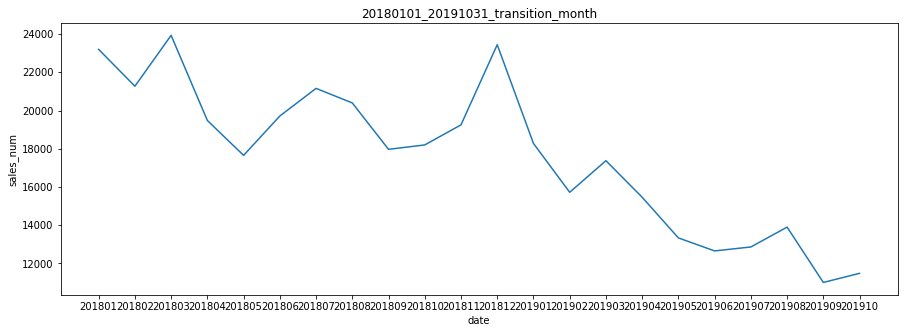

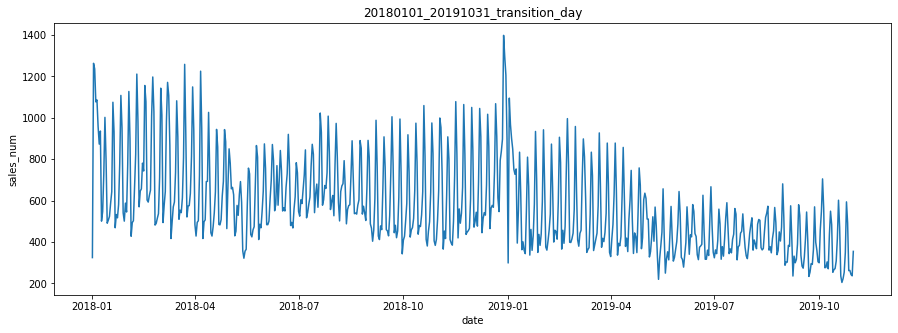

In [15]:
train_data_cinema = train_data.query("wide_categoryName == '映画'")

train_data_cinema_month = pd.DataFrame(train_data_cinema.groupby('month').size()).rename(columns={0:'sale_num'})
train_data_cinema_month = train_data_cinema_month.reset_index()

#月別の映画販売量推移（2018年1月~2019年10月））
plt.figure(figsize=(15,5))
plt.plot(train_data_cinema_month['month'], train_data_cinema_month['sale_num'])
plt.xlabel('date')
plt.ylabel('sales_num')
plt.title('20180101_20191031_transition_month')


#日別の映画販売量推移（2018年1月~2019年10月））
train_data_cinema_day = pd.DataFrame(train_data_cinema.groupby('date').size()).rename(columns={0:'sale_num'})
train_data_cinema_day = train_data_cinema_day.reset_index()

plt.figure(figsize=(15,5))
plt.plot(train_data_cinema_day['date'], train_data_cinema_day['sale_num'])
plt.xlabel('date')
plt.ylabel('sales_num')
plt.title('20180101_20191031_transition_day')

**ポイント**<br>
自己相関と偏自己相関<br>
周期性のあるデータのため、編自己相関にしても3~4週先の自分とは相関がある

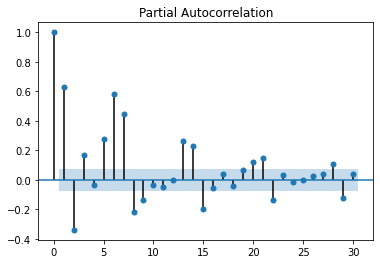

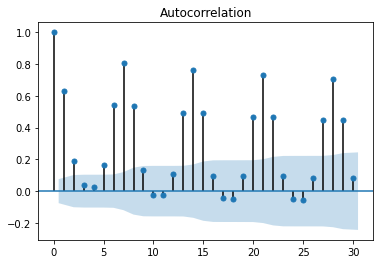

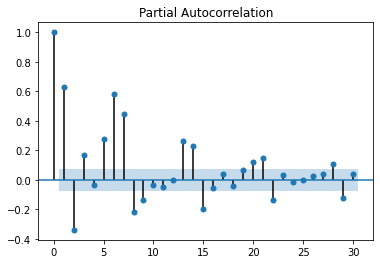

In [16]:
#上：自己相関　下：偏自己相関
tsaplots.plot_acf(train_data_cinema_day['sale_num'], lags=30)
tsaplots.plot_pacf(train_data_cinema_day['sale_num'], lags=30)

2018年1月の3ヶ月のみ

→**週次の時系列による周期性あり**

In [17]:
train_data_cinema_day.dtypes

date        datetime64[ns]
sale_num             int64
dtype: object

In [18]:
# #日別の映画販売量推移（2018年1月~2019年10月））
# train_data_cinema_day = pd.DataFrame(train_data_cinema.groupby('date').sum()).rename(columns={0:'sale_num'})
# train_data_cinema_day = train_data_cinema_day.reset_index()

# plt.figure(figsize=(15,5))
# filter_date = datetime.date(2018,12,31)
# plt.plot(train_data_cinema_day.query("date <= @filter_date")['date'], train_data_cinema_day.query("date <= @filter_date")['sale_num'])
# plt.xlabel('date')
# plt.ylabel('sales_num')
# plt.title('20180101_20191031_transition_day')

## 店舗別の売上推移

In [19]:
for i in sorted(list(train_data['store_id'].unique())):
    if i == 0 :
        train_data_store = pd.DataFrame(train_data.query("store_id == @i").groupby("month")['sale_num'].sum())
        train_data_store = train_data_store.rename(columns={'sale_num':'store_'+str(i)})
        train_data_store = train_data_store.reset_index()
    else:
        tmp_df = pd.DataFrame(train_data.query("store_id == @i").groupby("month")['sale_num'].sum())
        tmp_df = tmp_df.rename(columns={'sale_num':'store_'+str(i)})
        tmp_df = tmp_df.reset_index()
        train_data_store = pd.merge(train_data_store, tmp_df, on='month', how='inner')

In [20]:
train_data_store.head()

,month,store_0,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,store_11,store_12,store_13,store_14,store_15,store_16,store_17
0,201801,9487.0,4418.0,3167.0,1220.0,1949.0,3068.0,4851.0,6669.0,2897.0,3763.0,5973.0,2558.0,1915.0,6149.0,3426.0,2726.0,2491.0,2300.0
1,201802,9362.0,4502.0,2490.0,1420.0,2096.0,3466.0,5066.0,6710.0,2993.0,3211.0,4785.0,2522.0,1981.0,6695.0,3383.0,2605.0,2278.0,2175.0
2,201803,7022.0,3020.0,3034.0,5331.0,4246.0,3849.0,5909.0,7667.0,3313.0,3894.0,5863.0,2739.0,2103.0,7792.0,3934.0,2824.0,2584.0,2643.0
3,201804,4848.0,2236.0,2150.0,4304.0,2788.0,2951.0,4007.0,5787.0,2061.0,2693.0,4092.0,1993.0,1737.0,5750.0,2862.0,2150.0,1816.0,1766.0
4,201805,4975.0,2141.0,2031.0,4051.0,2582.0,1988.0,4355.0,5196.0,1635.0,2485.0,4366.0,2009.0,1489.0,5455.0,2904.0,2083.0,1797.0,1883.0


Text(0.5, 1.0, '20180101_20191031_transition_day')

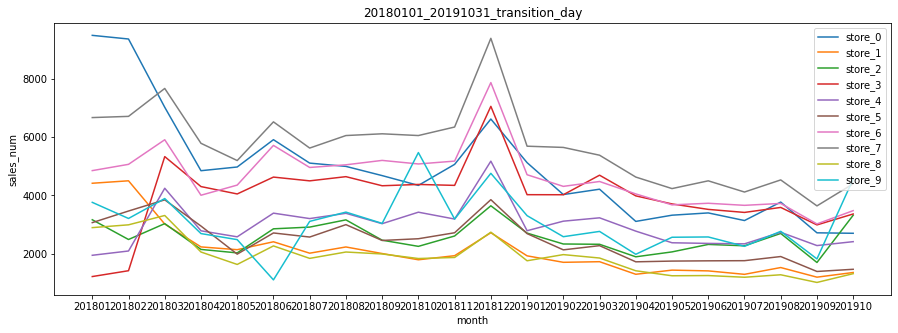

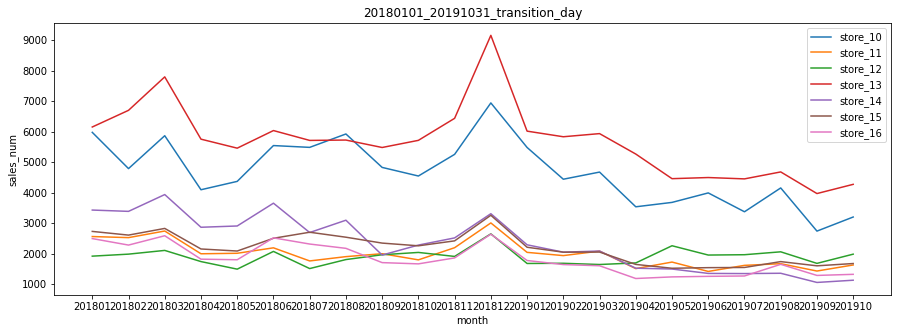

In [21]:
l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14,l15,l16 = 'store_0', 'store_1',  'store_2', 'store_3',\
        'store_4', 'store_5',  'store_6', 'store_7',  'store_8', 'store_9',\
         'store_10', 'store_11',  'store_12', 'store_13',  'store_14', 'store_15',  'store_16'

#1~10店舗
plt.figure(figsize=(15,5))
filter_date = datetime.date(2018,3,31)
plt.plot(train_data_store['month'], train_data_store['store_0'], label=l0)
plt.plot(train_data_store['month'], train_data_store['store_1'], label=l1)
plt.plot(train_data_store['month'], train_data_store['store_2'], label=l2)
plt.plot(train_data_store['month'], train_data_store['store_3'], label=l3)
plt.plot(train_data_store['month'], train_data_store['store_4'], label=l4)
plt.plot(train_data_store['month'], train_data_store['store_5'], label=l5)
plt.plot(train_data_store['month'], train_data_store['store_6'], label=l6)
plt.plot(train_data_store['month'], train_data_store['store_7'], label=l7)
plt.plot(train_data_store['month'], train_data_store['store_8'], label=l8)
plt.plot(train_data_store['month'], train_data_store['store_9'], label=l9)

plt.xlabel('month')
plt.ylabel('sales_num')
plt.legend()
plt.title('20180101_20191031_transition_day')

#11~17店舗
plt.figure(figsize=(15,5))
filter_date = datetime.date(2018,3,31)
plt.plot(train_data_store['month'], train_data_store['store_10'], label=l10)
plt.plot(train_data_store['month'], train_data_store['store_11'], label=l11)
plt.plot(train_data_store['month'], train_data_store['store_12'], label=l12)
plt.plot(train_data_store['month'], train_data_store['store_13'], label=l13)
plt.plot(train_data_store['month'], train_data_store['store_14'], label=l14)
plt.plot(train_data_store['month'], train_data_store['store_15'], label=l15)
plt.plot(train_data_store['month'], train_data_store['store_16'], label=l16)


plt.xlabel('month')
plt.ylabel('sales_num')
plt.legend()
plt.title('20180101_20191031_transition_day')

# 特徴量の作成

予測モデルが月単位の販売数量（目的変数）を追加

データを日別から月別に変換

In [27]:
train_data_one = pd.DataFrame(train_data.groupby(["month", 'store_id', "product_id"])['sale_num'].sum())
train_data_one = train_data_one[['sale_num']]
train_data_one = train_data_one.reset_index()
train_data_one.head()

,month,store_id,product_id,sale_num
0,201801,0,1000001,6.0
1,201801,0,1000002,2.0
2,201801,0,1000004,1.0
3,201801,0,1000005,8.0
4,201801,0,1000006,2.0


In [28]:
train_data_month = train_data.groupby(["store_id", "product_id", 'month'])['sale_num'].sum()
train_data_month = train_data_month.reset_index()
train_data_month = train_data_month.rename(columns={'sale_num':'sale_num_monthly'})
train_data = pd.merge(train_data, train_data_month, on=['store_id', 'product_id', 'month'], how='inner')

## 時系列データ

### 曜日

<BarContainer object of 7 artists>

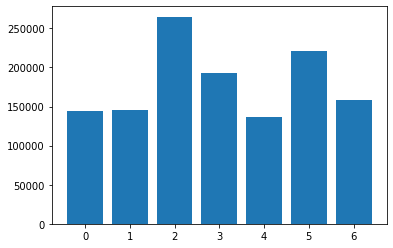

In [29]:
train_data['dayofweek'] = train_data['date'].apply(lambda x: x.weekday())
plt.bar(train_data["dayofweek"].unique(), train_data.groupby("dayofweek")['sale_num'].sum())

### 年月日

月は、target_encodingにて特徴量作成

In [30]:
train_data.head()

,date,store_id,product_id,product_price,sale_num,month,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName,sale_num_monthly,dayofweek
0,2018-01-01,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,0
1,2018-01-02,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,1
2,2018-01-14,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,6
3,2018-01-25,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,3
4,2018-01-31,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,2


In [31]:
train_data['holiday'] = train_data['date'].apply(lambda x:1 if (x.weekday() >= 5)or(jpholiday.is_holiday(x)) else 0)

In [32]:
train_data.head()

,date,store_id,product_id,product_price,sale_num,month,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName,sale_num_monthly,dayofweek,holiday
0,2018-01-01,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,0,1
1,2018-01-02,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,1,0
2,2018-01-14,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,6,1
3,2018-01-25,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,3,0
4,2018-01-31,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,2,0


### トレンド

In [33]:
train_data.head()

,date,store_id,product_id,product_price,sale_num,month,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName,sale_num_monthly,dayofweek,holiday
0,2018-01-01,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,0,1
1,2018-01-02,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,1,0
2,2018-01-14,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,6,1
3,2018-01-25,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,3,0
4,2018-01-31,9,1000001,420,1.0,201801,100,映画 - DVD,映画,DVD,5.0,2,0


In [34]:
date_group = train_data.groupby("month")
date_group.count()

,date,store_id,product_id,product_price,sale_num,product_categoryId,product_categoryName,wide_categoryName,narrow_categoryName,sale_num_monthly,dayofweek,holiday
month,,,,,,,,,,,,
201801,62087,62087,62087,62087,62087,62087,62087,62087,62087,62087,62087,62087
201802,59395,59395,59395,59395,59395,59395,59395,59395,59395,59395,59395,59395
201803,65484,65484,65484,65484,65484,65484,65484,65484,65484,65484,65484,65484
201804,50949,50949,50949,50949,50949,50949,50949,50949,50949,50949,50949,50949
201805,48875,48875,48875,48875,48875,48875,48875,48875,48875,48875,48875,48875
201806,55827,55827,55827,55827,55827,55827,55827,55827,55827,55827,55827,55827
201807,55921,55921,55921,55921,55921,55921,55921,55921,55921,55921,55921,55921
201808,58269,58269,58269,58269,58269,58269,58269,58269,58269,58269,58269,58269
201809,51204,51204,51204,51204,51204,51204,51204,51204,51204,51204,51204,51204


In [35]:
train_data['narrow_categoryName'].unique()

array(['DVD', '通常版', 'その他', 'ゲーム機C', 'ブルーレイ', 'ゲーム機B', '小型ゲーム',
       'カード、パズル等', 'フィギュア', 'PCソフト', 'ブルーレイ3D', 'ぬいぐるみ', 'ゲーム機A', 'セット商品',
       'ボードゲーム', 'CD', 'ガジェット類', 'オーディオブック_タイプA', '記念品_タイプA', '記念品_タイプB',
       '教育用', '付属品(購入特典)', 'オーディオブック_タイプB', 'レコード'], dtype=object)

## これからのタスク

・売り上げの幅を金額にする<br>
・移動平均を出す<br>
・異常値はあるか<br>
・自己相関を出す<br>
・ラグnの移動平均<br>
・偏自己相関を出す
